## Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# have matplotlib visuals appear in the notebook 

%matplotlib inline

In [3]:
# define path
path = '/Users/Cel/Documents/Data Analytics/6. Maine Fisheries Landings'

In [17]:
# import data
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'landings_clean.csv'), index_col = False)

## Data cleaning

In [18]:
df.columns

Index(['year', 'species', 'port', 'county', 'weight_type', 'weight', 'value',
       'number_harvesters', 'price_per_lb'],
      dtype='object')

#### Missing values

In [19]:
df.isnull().sum()

year                 0
species              0
port                 0
county               0
weight_type          0
weight               0
value                0
number_harvesters    0
price_per_lb         0
dtype: int64

#### Duplicates

In [20]:
dups = df.duplicated()

In [22]:
dups.shape # no dups

(4889,)

#### Extreme values

/var/folders/h2/jmnpmtkj7wl_jwjm4dq4g_gr0000gn/T/ipykernel_27659/1232294432.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price_per_lb'], bins=25) # Shows extreme values


<Axes: xlabel='price_per_lb', ylabel='Density'>

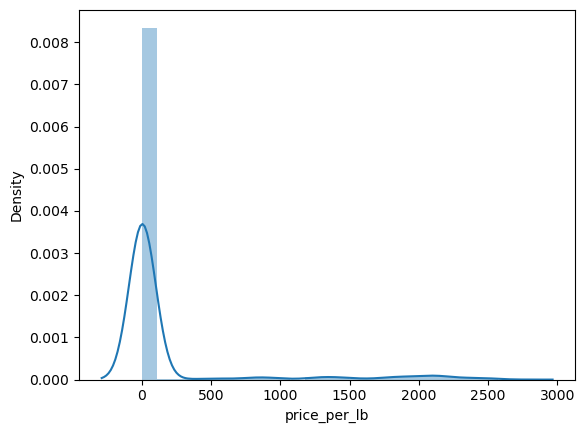

In [23]:
sns.distplot(df['price_per_lb'], bins=25) # Shows extreme values

In [28]:
# price of elver is distorting other species prices so we'll make another histogram exclusing elver
df_no_elver = df[df['species'] != 'Elver']

In [29]:
df_no_elver

year                species            port         county  weight_type  \
0     2008             Bloodworms         Addison     Washington  Live Pounds   
1     2008             Bloodworms      Bar Harbor        Hancock  Live Pounds   
2     2008             Bloodworms     Bass Harbor        Hancock  Live Pounds   
3     2008             Bloodworms            Bath      Sagadahoc  Live Pounds   
4     2008             Bloodworms           Beals     Washington  Live Pounds   
...    ...                    ...             ...            ...          ...   
4884  2022  Tuna Atlantic Bluefin   South Bristol        Lincoln  Live Pounds   
4885  2022  Tuna Atlantic Bluefin  Tenants Harbor           Knox  Live Pounds   
4886  2022  Tuna Atlantic Bluefin           Wells           York  Live Pounds   
4887  2022     Unidentified Catch     Other Maine  Not-Specified  Live Pounds   
4888  2022            Whelk Waved     Other Maine  Not-Specified  Live Pounds   

           weight        value  number_harvesters  price_per_lb  
0        18934.19    208982.04                145     11.037284  
1         1396.62     15276.99                 31     10.938544  
2           42.09       448.58                  3     10.657638  
3         9408.14    101804.90                 60     10.820938  
4         1760.18     18989.88                 75     10.788601  
...           ...          ...                ...           ...  
4884     11543.13     57104.75                  9      4.947077  
4885      7456.25     31216.52                  3      4.186625  
4886     14450.25     67219.96                 10      4.651820  
4887  31154845.48  91045138.28                 47      2.922343  
4888      2421.00      4064.50                 16      1.678852  

[4364 rows x 9 columns]

/var/folders/h2/jmnpmtkj7wl_jwjm4dq4g_gr0000gn/T/ipykernel_27659/2345816772.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_no_elver['price_per_lb'], bins=35)


<Axes: xlabel='price_per_lb', ylabel='Density'>

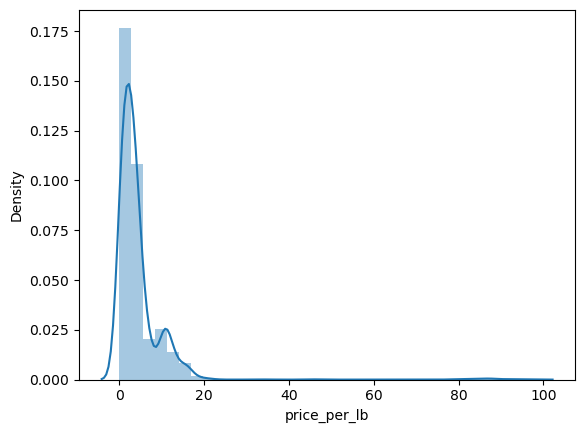

In [32]:
# histogram excluding elver
sns.distplot(df_no_elver['price_per_lb'], bins=35)

Price per pound doesn't seem to have any extreme values

## Data prep for regression analysis

Hypothesis: As the total weight of lobster harvested increases, the price per pound will decrease. 

In [34]:
# create a lobster data frame
lobster = df[df['species'] == 'Lobster American']

In [35]:
lobster

year           species           port      county  weight_type  \
182   2008  Lobster American        Addison  Washington  Live Pounds   
183   2008  Lobster American  Bailey Island  Cumberland  Live Pounds   
184   2008  Lobster American     Bar Harbor     Hancock  Live Pounds   
185   2008  Lobster American    Bass Harbor     Hancock  Live Pounds   
186   2008  Lobster American          Beals  Washington  Live Pounds   
...    ...               ...            ...         ...          ...   
4749  2022  Lobster American        Trenton     Hancock  Live Pounds   
4750  2022  Lobster American     Vinalhaven        Knox  Live Pounds   
4751  2022  Lobster American          Wells        York  Live Pounds   
4752  2022  Lobster American  Winter Harbor     Hancock  Live Pounds   
4753  2022  Lobster American           York        York  Live Pounds   

          weight         value  number_harvesters  price_per_lb  
182    874072.35  2.811849e+06                 80      3.216952  
183   1300961.05  4.380685e+06                100      3.367269  
184    749213.48  2.761140e+06                 71      3.685385  
185    860515.00  3.237509e+06                 89      3.762292  
186   1463538.05  4.777284e+06                173      3.264202  
...          ...           ...                ...           ...  
4749   223031.45  9.568708e+05                 17      4.290295  
4750  6960663.70  3.023618e+07                188      4.343864  
4751    24907.00  1.156994e+05                  6      4.645256  
4752  1818154.05  6.541451e+06                 57      3.597853  
4753   940215.45  4.266021e+06                 25      4.537280  

[1114 rows x 9 columns]

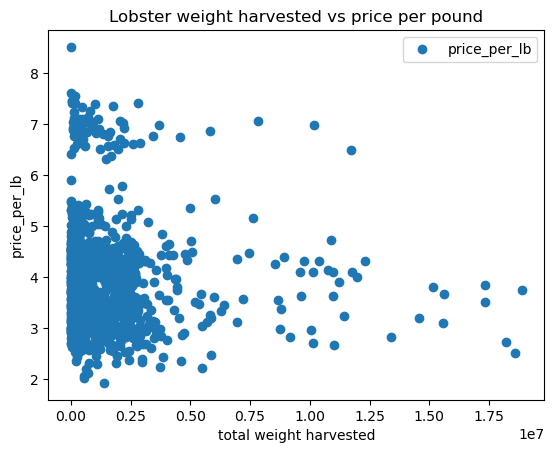

In [59]:
# Create a scatterplot using matplotlib for another look at how the chosen variables plot against each other.

lobster.plot(x = 'weight', y='price_per_lb',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Lobster weight harvested vs price per pound')  
plt.xlabel('total weight harvested')  
plt.ylabel('price_per_lb')  
plt.show()

In [45]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = lobster['weight'].values.reshape(-1,1)
y = lobster['price_per_lb'].values.reshape(-1,1)

In [46]:
X

array([[ 874072.35],
       [1300961.05],
       [ 749213.48],
       ...,
       [  24907.  ],
       [1818154.05],
       [ 940215.45]])

In [42]:
y

array([[3.21695192],
       [3.36726875],
       [3.68538497],
       ...,
       [4.64525635],
       [3.59785325],
       [4.53728031]])

In [47]:
# Split data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Regression analysis

In [48]:
# Create a regression object.

regression = LinearRegression()  # This is the regression object, which will be fit onto the training set.

In [49]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [50]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

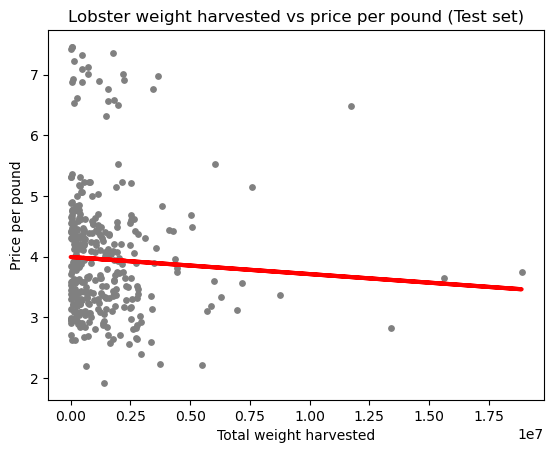

In [51]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Lobster weight harvested vs price per pound (Test set)')
plot_test.xlabel('Total weight harvested')
plot_test.ylabel('Price per pound')
plot_test.show()

In [52]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [53]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[-2.81554314e-08]]
Mean squared error:  1.1628667624262692
R2 score:  -0.003215608821445004


In [56]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

Actual  Predicted
0   6.915288   3.932220
1   4.290295   3.988488
2   3.392232   3.994570
3   5.230470   3.978516
4   3.093506   3.959788
5   4.172252   3.988056
6   4.887525   3.993989
7   4.375754   3.915824
8   3.882790   3.987047
9   2.972738   3.924035
10  3.211188   3.992151
11  3.300658   3.983124
12  3.185863   3.829591
13  4.455688   3.986961
14  2.634190   3.989843
15  4.293369   3.992902
16  3.655511   3.974161
17  4.196387   3.924432
18  2.227269   3.889533
19  3.918641   3.990864
20  3.423978   3.972163
21  3.131649   3.952624
22  3.953452   3.943581
23  4.070145   3.966396
24  2.978286   3.993200
25  4.400550   3.962620
26  4.756259   3.992825
27  4.693776   3.853239
28  5.309665   3.984010
29  3.395286   3.959494

## Conclusion

Based on the variability of data points along the regression line and the model summary statistics, this model didn't perform well. It has a very low r2 value, and the mean squared error is relatively high for the small spread in y-values. While total amount harvested is likely a factor to the price per pound of lobster, it isn't the only factor. Influences like demand from many different markets (both local and international) have a huge impact on price. Especially when the total amount harvested is relatively low, it doesn't seem to influence price per pound at all (hence the wide disparity in price for lower harvest amounts). 